In [1]:
import torch
from transformers import AlignProcessor, AlignModel
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ruamel_yaml as yaml
import random
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

from src.datasets.meme_text_dataloader import get_meme_text_dataloader
from src.utilities import *
from src.models.align_base import align_base

from src.models.albef import ALBEF
from src.models.vit import interpolate_pos_embed
from src.models.tokenization_bert import BertTokenizer

from src.utilities import create_dataset, create_loader
from src.evaluation import evaluation, itm_eval


# Load the dataset and the model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else  'cpu')
# Load images into a Dataset, but the pixels will be transformed into list elements, which is not efficient.
meme_loader = get_meme_text_dataloader('memecap', (-1, -1))
# meme_loader.load_datasets(0, 10)
# print(meme_loader.dataset)
# print('meme shape:', np.array(meme_loader.dataset['test']['image'][0]).shape)
# visualize_meme(meme_loader.dataset['test']['image'][0], meme_loader.dataset['test']['caption'][0])
# # TODO (maybe?): Verify if the loading process works well, and if every meme gets resized and cropped correctly.

# load memes and texts
meme_loader.load_datasets(splits=['test']) # test or trainval

Split: test. Length: 559 
Finished loading memes


In [3]:
meme_loader.dataset['test']['caption']

['Husband feels great after having their wife fall in love with him again after getting amnesia.',
 'Meme poster is not interested in paying for a new phone just for an added camera.',
 "The Simpsons was correct about it's use of Trump and Greta Thurnberg. ",
 "Meme poster realizes there's always a mass plague in the 20s.",
 'Meme poster can relate to a parent being sick and tired of questions.',
 'Meme poster is annoyed with anti-vaxxer logic.',
 "The person who wrote the is comparing saying Americans don't believe in free healthcare ",
 'Meme poster is mad that colleges will pay your way if you are an athlete, but not as much for academics.',
 'Meme poster is making fun of the FBI for monitoring memes online.',
 'Meme poster felt they conquered water when they opened their eyes in the pool when they were 8.',
 "Meme poster is mad that Netflix/tv shows/movies use adults who are in their 30's to play high school students.",
 'Meme poster warns people of real life dangers of using a toi

# Evaluation
## ALIGN

In [4]:
align_model = align_base()

test_dataset = meme_loader.dataset['test']
# Preprocessing: resize and crop
inputs = align_model.processor(text=test_dataset['caption'], 
                               images=test_dataset['image'], 
                               return_tensors="pt")

In [5]:
from src.evaluation import similarity_align
from src.utilities import recall_at_k
# Calculate the similarity matrix of memes and texts.
text2image_si = similarity_align(inputs, align_model.model, device)
recall_at_k(text2image_si), recall_at_k(text2image_si.T)

torch.Size([559, 640])
torch.Size([559, 640])


({'t2i_r1': 0.5402504472271914,
  't2i_r5': 0.7262969588550984,
  't2i_r10': 0.774597495527728,
  't2i_r_mean': 0.6803816338700059},
 {'t2i_r1': 0.5688729874776386,
  't2i_r5': 0.7423971377459749,
  't2i_r10': 0.7889087656529516,
  't2i_r_mean': 0.7000596302921883})

Text(0.5, 1.0, 'The text-meme retrieval probabilities matrix')

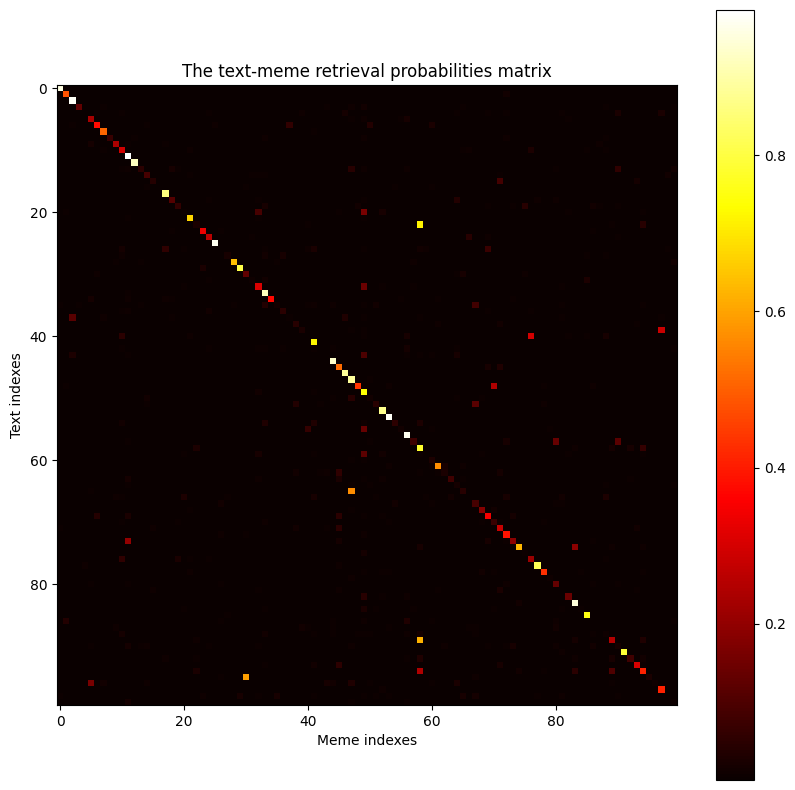

In [6]:
result = text2image_si.softmax(dim=1)[:100, :100]
plt.figure(figsize=(10, 10))
# Plot the tensor as a heatmap
plt.imshow(result, cmap='hot')
plt.colorbar()  # Adds a colorbar to show the scale
plt.ylabel('Text indexes')
plt.xlabel('Meme indexes')
plt.title('The text-meme retrieval probabilities matrix')


## CLIP

In [7]:
from src.models.clip import clip
clip_model = clip()

In [8]:
# Preprocessing: resize and crop
test_dataset = meme_loader.dataset['test']
inputs = clip_model.processor(text=test_dataset['caption'], 
                               images=test_dataset['image'], 
                               return_tensors="pt", 
                               padding=True)

In [9]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [10]:
from src.evaluation import similarity_clip
from src.utilities import recall_at_k
# Calculate the similarity matrix of memes and texts.
text2image_si = similarity_clip(inputs, clip_model, device)
recall_at_k(text2image_si), recall_at_k(text2image_si.T)

torch.Size([559, 512])
torch.Size([559, 512])


({'t2i_r1': 0.45796064400715564,
  't2i_r5': 0.6654740608228981,
  't2i_r10': 0.7334525939177102,
  't2i_r_mean': 0.6189624329159212},
 {'t2i_r1': 0.518783542039356,
  't2i_r5': 0.7209302325581395,
  't2i_r10': 0.7728085867620751,
  't2i_r_mean': 0.6708407871198568})

Text(0.5, 1.0, 'The text-meme retrieval probabilities matrix')

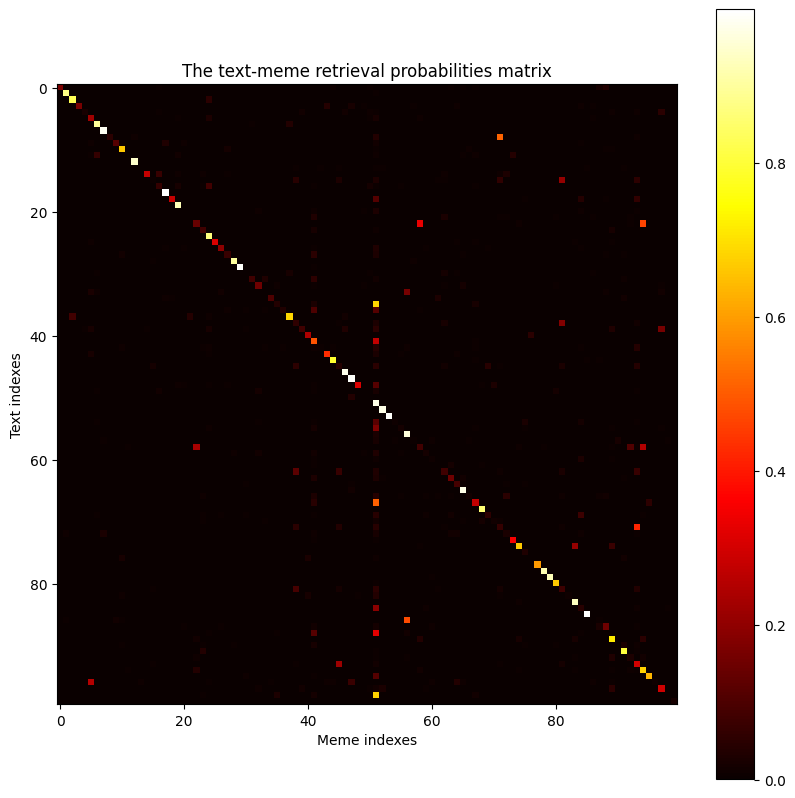

In [11]:
result = text2image_si.softmax(dim=1)[:100, :100]
plt.figure(figsize=(10, 10))
# Plot the tensor as a heatmap
plt.imshow(result[:100, :100], cmap='hot')
plt.colorbar()  # Adds a colorbar to show the scale
plt.ylabel('Text indexes')
plt.xlabel('Meme indexes')
plt.title('The text-meme retrieval probabilities matrix')


# ALBEF


In [3]:
# fix the seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True
config = yaml.load(open('./configs/Retrieval_memecap.yaml', 'r'), Loader=yaml.Loader)
text_encoder = 'bert-base-uncased'
checkpoint = 'flickr30k.pth'
device = torch.device('cuda')

In [4]:
#### Dataset #### 
print("Creating retrieval dataset")
test_dataset = create_dataset(config)  

samplers = [None, None, None]
test_loader = create_loader([test_dataset],samplers,
                                batch_size=[config['batch_size_test']],
                                num_workers=[4,4,4],
                                is_trains=[False], 
                                collate_fns=[None])[0]

tokenizer = BertTokenizer.from_pretrained(text_encoder) # 'bert-base-uncased'

Creating retrieval dataset
559


In [5]:
#### Model #### 
model = ALBEF(config=config, text_encoder=text_encoder, tokenizer=tokenizer)
state_dict = torch.load(checkpoint, map_location='cpu') 

# reshape positional embedding to accomodate for image resolution change
pos_embed_reshaped = interpolate_pos_embed(state_dict['visual_encoder.pos_embed'],model.visual_encoder)         
state_dict['visual_encoder.pos_embed'] = pos_embed_reshaped

for key in list(state_dict.keys()): # Key names adjustment
    if 'bert' in key:
        encoder_key = key.replace('bert.','')         
        state_dict[encoder_key] = state_dict[key] 
        del state_dict[key]                
msg = model.load_state_dict(state_dict,strict=False)  

print('load checkpoint from %s'%checkpoint)
print(msg)  
    
model = model.to(device)   
model_without_ddp = model

load checkpoint from flickr30k.pth
_IncompatibleKeys(missing_keys=['image_queue', 'text_queue', 'idx_queue', 'queue_ptr', 'visual_encoder_m.cls_token', 'visual_encoder_m.pos_embed', 'visual_encoder_m.patch_embed.proj.weight', 'visual_encoder_m.patch_embed.proj.bias', 'visual_encoder_m.blocks.0.norm1.weight', 'visual_encoder_m.blocks.0.norm1.bias', 'visual_encoder_m.blocks.0.attn.qkv.weight', 'visual_encoder_m.blocks.0.attn.qkv.bias', 'visual_encoder_m.blocks.0.attn.proj.weight', 'visual_encoder_m.blocks.0.attn.proj.bias', 'visual_encoder_m.blocks.0.norm2.weight', 'visual_encoder_m.blocks.0.norm2.bias', 'visual_encoder_m.blocks.0.mlp.fc1.weight', 'visual_encoder_m.blocks.0.mlp.fc1.bias', 'visual_encoder_m.blocks.0.mlp.fc2.weight', 'visual_encoder_m.blocks.0.mlp.fc2.bias', 'visual_encoder_m.blocks.1.norm1.weight', 'visual_encoder_m.blocks.1.norm1.bias', 'visual_encoder_m.blocks.1.attn.qkv.weight', 'visual_encoder_m.blocks.1.attn.qkv.bias', 'visual_encoder_m.blocks.1.attn.proj.weight', 'v

In [6]:
score_test_i2t, score_test_t2i, sims_matrix_t2i = evaluation(model_without_ddp, test_loader, tokenizer, device, config)
test_result = itm_eval(score_test_i2t.numpy(), score_test_t2i.numpy(), test_loader.dataset.txt2img, test_loader.dataset.img2txt)    
test_result

Computing features for evaluation...
Calculating image to text scores
Calculating text to image scores
Evaluation time 0:05:47
scores_i2t: (559, 559) scores_t2i: (559, 559)


{'txt_r1': 0.11985688729874776,
 'txt_r5': 0.2003577817531306,
 'txt_r10': 0.25402504472271914,
 'txt_r_mean': 0.19141323792486584,
 'img_r1': 0.09302325581395349,
 'img_r5': 0.15742397137745975,
 'img_r10': 0.2110912343470483,
 'img_r_mean': 0.15384615384615383,
 'r_mean': 0.17262969588550983}

Text(0.5, 1.0, 'The text-meme retrieval probabilities matrix')

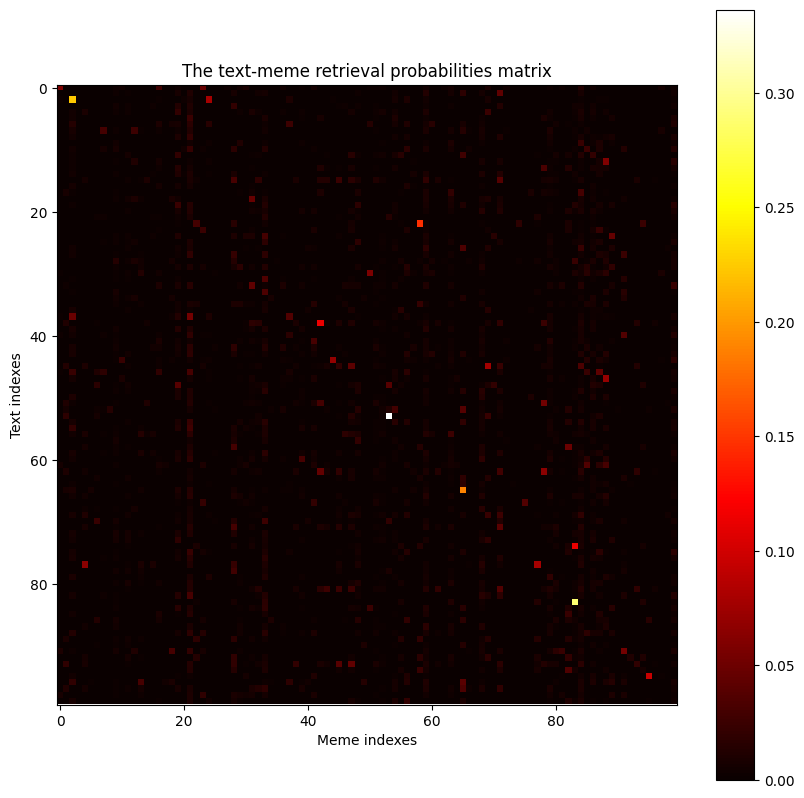

In [7]:
result = score_test_t2i.softmax(dim=1)[:100, :100]
plt.figure(figsize=(10, 10))
# Plot the tensor as a heatmap
plt.imshow(result[:100, :100], cmap='hot')
plt.colorbar()  # Adds a colorbar to show the scale
plt.ylabel('Text indexes')
plt.xlabel('Meme indexes')
plt.title('The text-meme retrieval probabilities matrix')
